In [128]:
# import opencv 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os


generated_img = cv2.imread('jaw.png', cv2.IMREAD_COLOR)
source_img = cv2.imread('source.jpg', cv2.IMREAD_COLOR)

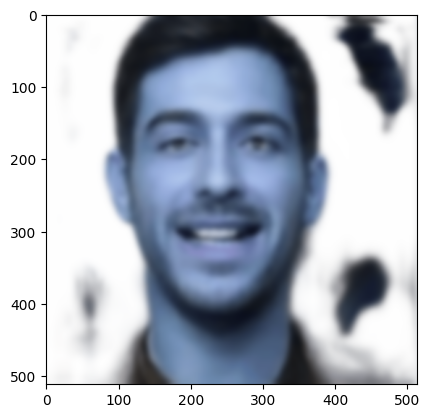

In [2]:
#gaussian blur the image 
generated_img_blurred = cv2.GaussianBlur(generated_img, (21, 21), 0)
plt.imshow(generated_img_blurred)

In [3]:
plt.imsave('generated_img_blurred.png', generated_img_blurred)

In [4]:
!pip install -q mediapipe


zsh:1: /Users/xiaowenyuan/Library/Python/3.9/bin/pip: bad interpreter: /Library/Developer/CommandLineTools/usr/bin/python3: no such file or directory


In [5]:
#@title Start downloading here.
!wget -O deeplabv3.tflite -q https://storage.googleapis.com/mediapipe-models/image_segmenter/deeplab_v3/float32/1/deeplab_v3.tflite

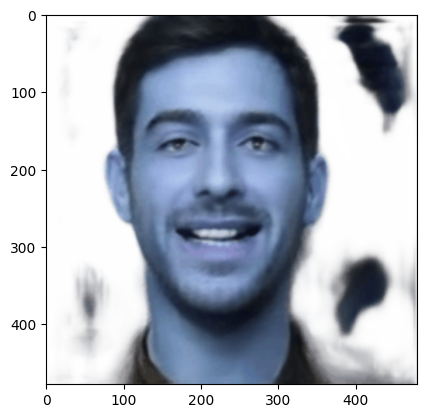

In [6]:
import cv2
import math

# Height and width that will be used by the model
DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480

# Performs resizing and showing the image
def resize_and_show(image):
  h, w = image.shape[:2]
  if h < w:
    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
  plt.imshow(img)



resize_and_show(generated_img)

(360, 540, 3)


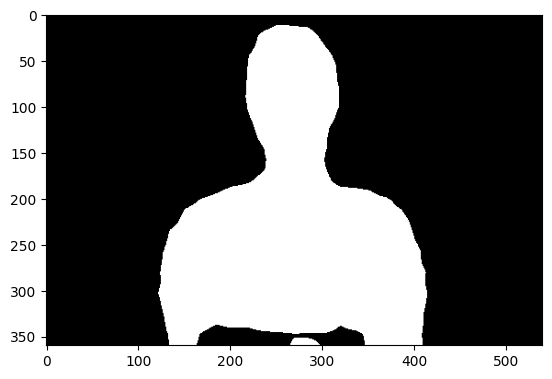

In [115]:
import numpy as np
import mediapipe as mp

from mediapipe.tasks import python
from mediapipe.tasks.python import vision


BG_COLOR = (192, 192, 192) # gray
MASK_COLOR = (255, 255, 255) # white


# Create the options that will be used for ImageSegmenter
base_options = python.BaseOptions(model_asset_path='deeplabv3.tflite')
options = vision.ImageSegmenterOptions(base_options=base_options,
                                       output_confidence_masks= True,
                                       output_category_mask=True)

# Create the image segmenter
with vision.ImageSegmenter.create_from_options(options) as segmenter:

    # Create the MediaPipe image file that will be segmented
    image = mp.Image.create_from_file("source.jpg")

    # Retrieve the masks for the segmented image
    segmentation_result = segmenter.segment(image)
    category_mask = segmentation_result.category_mask
    confidence_mask = segmentation_result.confidence_masks
    
    mask = np.stack((confidence_mask[0].numpy_view(),) * 3, axis=-1) > 0.05
    
    # flip the mask
    mask = 1 - mask
    # Generate solid color images for showing the output segmentation mask.
    image_data = image.numpy_view()
    # fg green
    fg_image = (255, 255, 255)
    bg_image = (0, 0, 0)

    condition = np.stack((category_mask.numpy_view(),) * 3, axis=-1) > 10
    print(condition.shape)
    output_image = np.where(mask, fg_image, bg_image)

    plt.imshow(output_image)

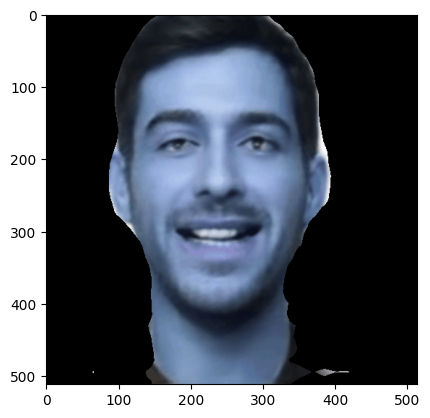

In [8]:
# use output image as mask to remove the background of the generated image

# resize the mask to the size of the generated image
mask = cv2.resize(output_image.astype(np.uint8), (generated_img.shape[1], generated_img.shape[0]))

# apply the mask to the generated image
masked_image = cv2.bitwise_and(generated_img, mask)
plt.imshow(masked_image)

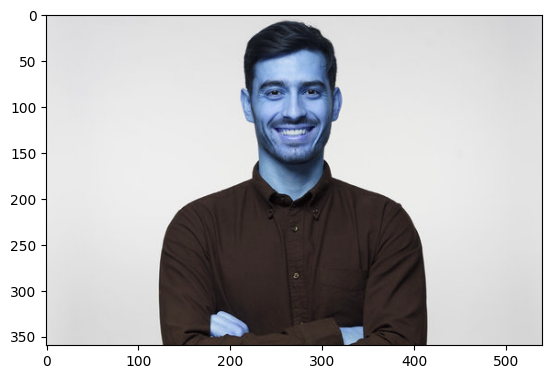

In [129]:
plt.imshow(source_img)

In [10]:
!wget -O face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task

In [17]:
base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes= False,
                                       output_facial_transformation_matrixes=False,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)
masked_image= cv2.resize(masked_image, (source_img.shape[1], source_img.shape[0]))
jaw = mp.Image(image_format=mp.ImageFormat.SRGB, data = source_image)
source = mp.Image(image_format=mp.ImageFormat.SRGB,data = source_img)
jaw_detection_result = detector.detect(image)
source_detection_result = detector.detect(source)
jaw_left = (jaw_detection_result.face_landmarks[0][468].x * masked_image.shape[1], jaw_detection_result.face_landmarks[0][468].y * masked_image.shape[0])
jaw_right = (jaw_detection_result.face_landmarks[0][473].x * masked_image.shape[1]), int(jaw_detection_result.face_landmarks[0][473].y * masked_image.shape[0])
source_left = (source_detection_result.face_landmarks[0][468].x * source_img.shape[1]), int(source_detection_result.face_landmarks[0][468].y * source_img.shape[0])
source_right = (source_detection_result.face_landmarks[0][473].x * source_img.shape[1]), int(source_detection_result.face_landmarks[0][473].y * source_img.shape[0])
# jaw eyes distance / source eyes distance 
jaw_center = (np.mean([jaw_left[0], jaw_right[0]]), np.mean([jaw_left[1], jaw_right[1]]))
jaw_source_scale = np.linalg.norm(np.array(jaw_left) - np.array(jaw_right)) / np.linalg.norm(np.array(source_left) - np.array(source_right))
source_center = (np.mean([source_left[0], source_right[0]]), np.mean([source_left[1], source_right[1]]))

W20240507 20:07:30.100814 4118117056 face_landmarker_graph.cc:168] Face blendshape model contains CPU only ops. Sets FaceBlendshapesGraph acceleration to Xnnpack.


In [12]:
def resize_image(original_image, scale):
    original_shape = original_image.shape
    resized_img = cv2.resize(original_image, (int(original_shape[1] / scale), int(original_shape[0] / scale)))
    padding_x = (original_shape[1] - resized_img.shape[1]) // 2
    padding_y = (original_shape[0] - resized_img.shape[0]) // 2
    return cv2.copyMakeBorder(resized_img, padding_y, padding_y, padding_x, padding_x, cv2.BORDER_CONSTANT, value=0)
    
    

In [30]:
masked_image_resized = resize_image(masked_image, jaw_source_scale)

In [34]:
xchange = (jaw_center[0] - jaw_left[0]) * (1 - 1/jaw_source_scale)
xyscale = masked_image.shape[1] / masked_image_resized.shape[1]
ychange = xchange / xyscale
jaw_left_resized = (jaw_left[0] + xchange, jaw_left[1] + ychange)
jaw_right_resized = (jaw_right[0] - xchange, jaw_right[1] + ychange)

In [35]:
jaw_center = (int(np.mean([jaw_left_resized[0], jaw_right_resized[0]])), int(np.mean([jaw_left_resized[1], jaw_right_resized[1]])))

In [36]:
(jaw_center[1] - jaw_left[1]) * (1 - 1/jaw_source_scale)

22.11788364006473

In [37]:
copy = masked_image_resized.copy()

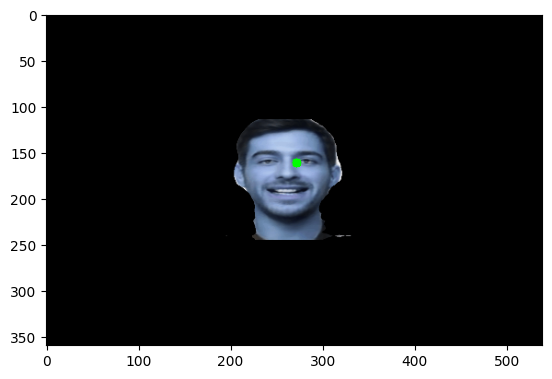

In [38]:
plt.imshow(cv2.circle(copy, (int(jaw_right_resized[0]), int(jaw_right_resized[1])), 5, (0, 255, 0), -1))

In [39]:
jaw = mp.Image(image_format=mp.ImageFormat.SRGB, data = masked_image_resized)
jaw_detection_result = detector.detect(jaw)

jaw_left = (jaw_detection_result.face_landmarks[0][468].x *  masked_image_resized.shape[1], jaw_detection_result.face_landmarks[0][468].y *  masked_image_resized.shape[0])
jaw_right = (jaw_detection_result.face_landmarks[0][473].x *  masked_image_resized.shape[1], jaw_detection_result.face_landmarks[0][473].y *  masked_image_resized.shape[0])
jaw_center = (int(np.mean([jaw_left[0], jaw_right[0]])), int(np.mean([jaw_left[1], jaw_right[1]]))) 


IndexError: list index out of range

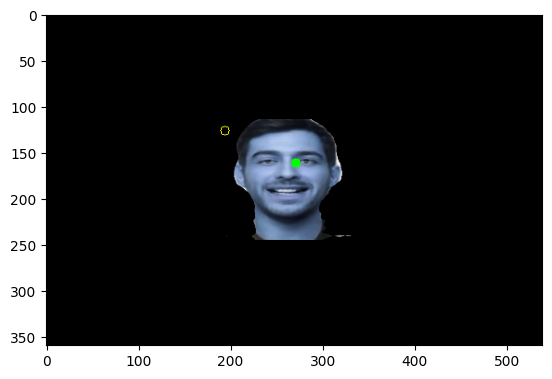

In [23]:
masked_image_resized_copy = masked_image_resized.copy()
plt.imshow(cv2.circle(masked_image_resized, (int(jaw_left[0]),int(jaw_left[1])), 5, (255, 255, 0), 1))

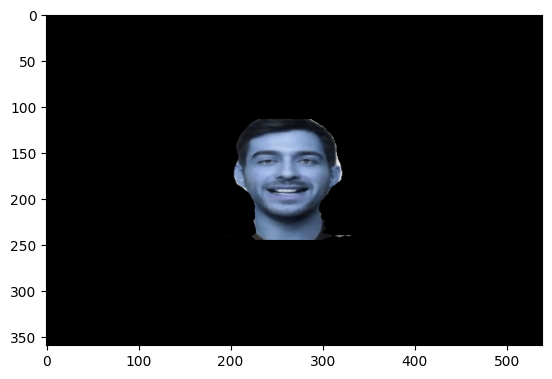

In [40]:
plt.imshow(masked_image_resized)

In [42]:
source_img_with_mask.shape

(360, 540, 3)

ValueError: cannot resize an array that references or is referenced
by another array in this way.
Use the np.resize function or refcheck=False

In [ ]:
plt.imshow(cv2.circle(masked_image_resized, (int(jaw_center[0]),int(jaw_center[1])), 5, (255, 0, 0), 1))

In [96]:
def overlay_images(source, target, source_center, target_center):
    assert source.shape == target.shape
    dx = source_center[0] - target_center[0] - 10
    dy = source_center[1] - target_center[1]
    
    height, width, _ = source.shape
    
    transformation_matrix = np.float32([[1, 0, dx], [0, 1, dy]])

    # Apply the translation to image1
    translated_image = cv2.warpAffine(target, transformation_matrix, (width, height))

    # Overlay the translated image onto image2
    overlaid_image = cv2.addWeighted(source, 0.2, translated_image, 1, 0)

    return translated_image, overlaid_image


In [46]:
source_img_with_mask = source_img.copy()
masked_image_resized = cv2.resize(masked_image_resized, (source_img_with_mask.shape[1], source_img_with_mask.shape[0])) 

In [ ]:
source_center

(268.0, 86.0)

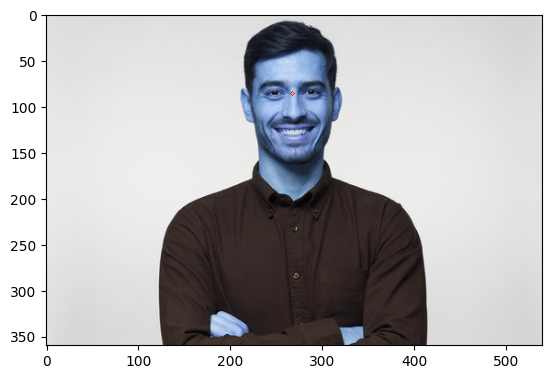

In [27]:
plt.imshow(cv2.circle(source_img, (int(source_center[0]),int(source_center[1])), 2, (255, 0, 0), 1))

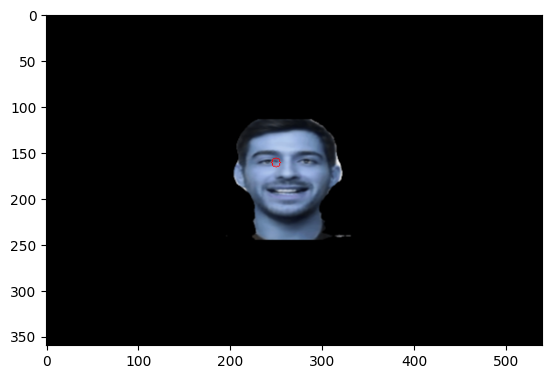

In [85]:
masked_image_resized_copy = masked_image_resized.copy()

plt.imshow(cv2.circle(masked_image_resized, (int(jaw_center[0]),int(jaw_center[1])), 5, (255, 0, 0), 1))

In [86]:
masked_image_resized = masked_image_resized_copy

In [103]:
source_image, overlay_image = overlay_images(source_img_with_mask,masked_image_resized, source_center, jaw_center)

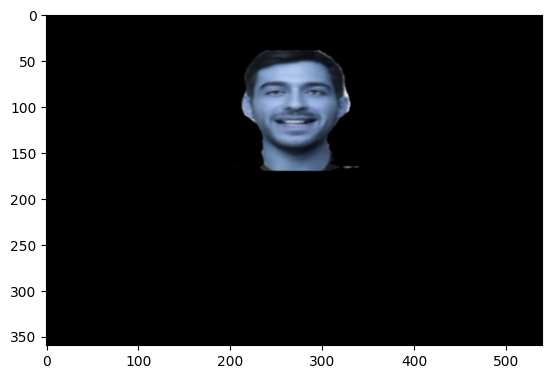

In [104]:
plt.imshow(source_image)

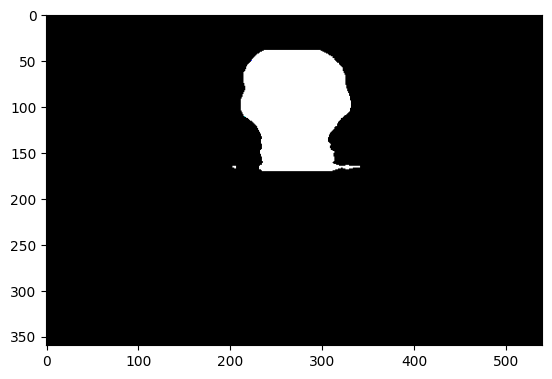

In [130]:
mask = np.where(source_image > 0 , 255, 0)
plt.imshow(source_mask) 

In [137]:
target_image.shape

(360, 540, 3)

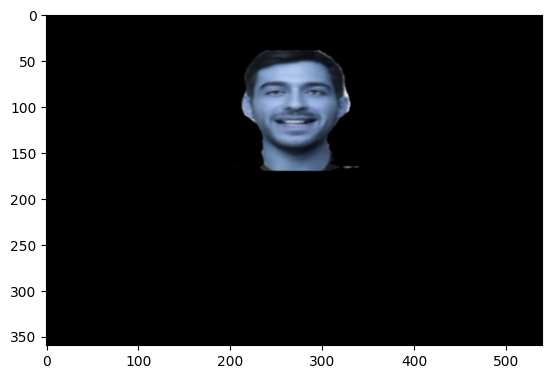

In [138]:
plt.imshow(target_image)

In [139]:
cv2.imwrite('target.png', target_image)


True

In [ ]:
output = cv2.seamlessClone(source, target, mask, offset, cv2.NORMAL_CLONE)

In [142]:
base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes= False,
                                       output_facial_transformation_matrixes=False,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)
jaw = mp.Image(image_format=mp.ImageFormat.SRGB, data = source_image)
jaw_detection_result = detector.detect(image)

jaw_left = (jaw_detection_result.face_landmarks[0][468].x * masked_image.shape[1], jaw_detection_result.face_landmarks[0][468].y * masked_image.shape[0])
jaw_right = (jaw_detection_result.face_landmarks[0][473].x * masked_image.shape[1]), int(jaw_detection_result.face_landmarks[0][473].y * masked_image.shape[0])

jaw_center = (int(np.mean([jaw_left[0], jaw_right[0]])), int(np.mean([jaw_left[1], jaw_right[1]])))

W20240507 22:39:16.887382 4118117056 face_landmarker_graph.cc:168] Face blendshape model contains CPU only ops. Sets FaceBlendshapesGraph acceleration to Xnnpack.


In [155]:
mask =  np.float32(mask)
source = np.float32(source_img)
target = np.float32(source_image)

In [158]:
output = cv2.seamlessClone(source, target, mask, jaw_center, cv2.NORMAL_CLONE)

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'seamlessClone'
> Overload resolution failed:
>  - Can't parse 'p'. Expected sequence length 2, got 1
>  - Can't parse 'p'. Expected sequence length 2, got 1


### Poisson Blending

In [ ]:

import argparse
import imageio

def poisson_blend(fg, mask, bg):
    """
    Poisson Blending.
    :param fg: (H, W, C) source texture / foreground object
    :param mask: (H, W, 1)
    :param bg: (H, W, C) target image / background
    :return: (H, W, C)
    """
    return 

def mixed_blend(fg, mask, bg):
    """EC: Mix gradient of source and target"""
    return fg * mask + bg * (1 - mask)


def color2gray(rgb_image):
    """Naive conversion from an RGB image to a gray image."""
    return cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)


def mixed_grad_color2gray(rgb_image):
    """EC: Convert an RGB image to gray image using mixed gradients."""
    return np.zeros_like(rgb_image)

In [ ]:
# Minimize ((v(x+1,y)−v(x,y))−(s(x+1,y)−s(x,y)))2
# , so the x-gradients of v should closely match the x-gradients of s.
# Minimize ((v(x,y+1)−v(x,y))−(s(x,y+1)−s(x,y)))2
# , so the y-gradients of v should closely match the x-gradients of s. Note that these could be solved while adding any constant value to v, so we will add one more objective:
# minimize (v(1,1)−s(1,1))2
# The top left corners of the two images should be the same color
import scipy.sparse
def get_intensity(image):
    gradx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    grady = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    return gradx, grady

imh, imw, nb = source_img.shape
im2var = np.arange(imh * imw).reshape((imh, imw)).astype(int)
A = scipy.sparse.lil_matrix((0, imh * imw), dtype=int)

    